In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
df_main = pd.read_csv('data/df_main.csv').drop(columns=["Unnamed: 0"])

In [3]:
# Classify all EU countries according to solar radiation intensity

eu_countries_solar_radiation_classification_dict = {
    'Austria': 'low',
    'Belgium': 'low',
    'Bulgaria': 'medium',
    'Croatia': 'medium',
    'Cyprus': 'very high',
    'Czech Republic': 'low',
    'Denmark': 'very low',
    'Estonia': 'low',
    'Finland': 'very low',
    'France': 'medium',
    'Germany': 'low',
    'Greece': 'high',
    'Hungary': 'medium',
    'Ireland': 'very low',
    'Italy': 'high',
    'Latvia': 'low',
    'Lithuania': 'low',
    'Luxembourg': 'low',
    'Malta': 'very high',
    'Netherlands': 'low',
    'Poland': 'low',
    'Portugal': 'high',
    'Romania': 'medium',
    'Slovak Republic': 'low',
    'Slovenia': 'medium',
    'Spain': 'very high',
    'Sweden': 'very low'}

In [4]:
# Load demographic data (Population and Area)
df_pop = pd.read_csv("data/eu_country_population.csv")
df_area = pd.read_csv("data/eu_country_area.csv")

df_pop = df_pop.rename(columns={'OBS_VALUE': "population"})
df_area = df_area.rename(columns={'OBS_VALUE': "area_[km2]"})

df_pop = df_pop[df_pop['geo'] != "EU27_2020"]
df_area = df_area[df_area['geo'] != "EU27_2020"]

In [5]:
country_abbr_dict = {
    'AT': 'Austria',
    'BE': 'Belgium',
    'BG': 'Bulgaria',
    'CY': 'Cyprus',
    'CZ': 'Czech Republic',
    'DE': 'Germany',
    'DK': 'Denmark',
    'EE': 'Estonia',
    'EL': 'Greece',
    'ES': 'Spain',
    'FI': 'Finland',
    'FR': 'France',
    'HR': 'Croatia',
    'HU': 'Hungary',
    'IE': 'Ireland',
    'IT': 'Italy',
    'LT': 'Lithuania',
    'LU': 'Luxembourg',
    'LV': 'Latvia',
    'MT': 'Malta',
    'NL': 'Netherlands',
    'PL': 'Poland',
    'PT': 'Portugal',
    'RO': 'Romania',
    'SE': 'Sweden',
    'SI': 'Slovenia',
    'SK': 'Slovak Republic'}

In [6]:
# Create dataframe with one row per country and aggregate demographic information
df_countries = df_pop[['geo', 'population']].merge(df_area[['geo', 'area_[km2]']], how='inner', on='geo')
df_countries['country_name'] = df_countries['geo'].map(country_abbr_dict)

# Add data about solar radiation classification
df_countries['solar_class'] = df_countries['country_name'].map(eu_countries_solar_radiation_classification_dict)

# Add data from df_main (solar energy production)
df_pivot = df_main.loc[(df_main["product"] == "Solar") & (df_main["year"] > 2013)].pivot_table(index="country_name", values="value", aggfunc="sum")
df_countries = df_countries.merge(df_pivot, how='inner', on='country_name')
df_countries = df_countries.rename(columns={'value': 'solar_power_[GWh]'})

# Calculate solar power intensity (production per area)
df_countries['solar_power_intensity_[GWh_per_km2]'] = df_countries['solar_power_[GWh]'] / df_countries["area_[km2]"]

In [7]:
df_countries

,geo,population,area_[km2],country_name,solar_class,solar_power_[GWh],solar_power_intensity_[GWh_per_km2]
0,AT,9104772,83878,Austria,low,16893,0.201400
1,BE,11742796,30667,Belgium,low,45496,1.483549
2,BG,6447710,110996,Bulgaria,medium,15196,0.136906
3,CY,920701,9253,Cyprus,very high,3056,0.330271
4,CZ,10827529,78871,Czech Republic,low,22700,0.287812
5,DE,84358845,357569,Germany,low,451662,1.263146
6,DK,5932654,42925,Denmark,very low,12549,0.292347
7,EE,1365884,45336,Estonia,low,1435,0.031653
8,EL,10413982,131694,Greece,high,49196,0.373563
9,ES,48085361,505983,Spain,very high,202357,0.399928


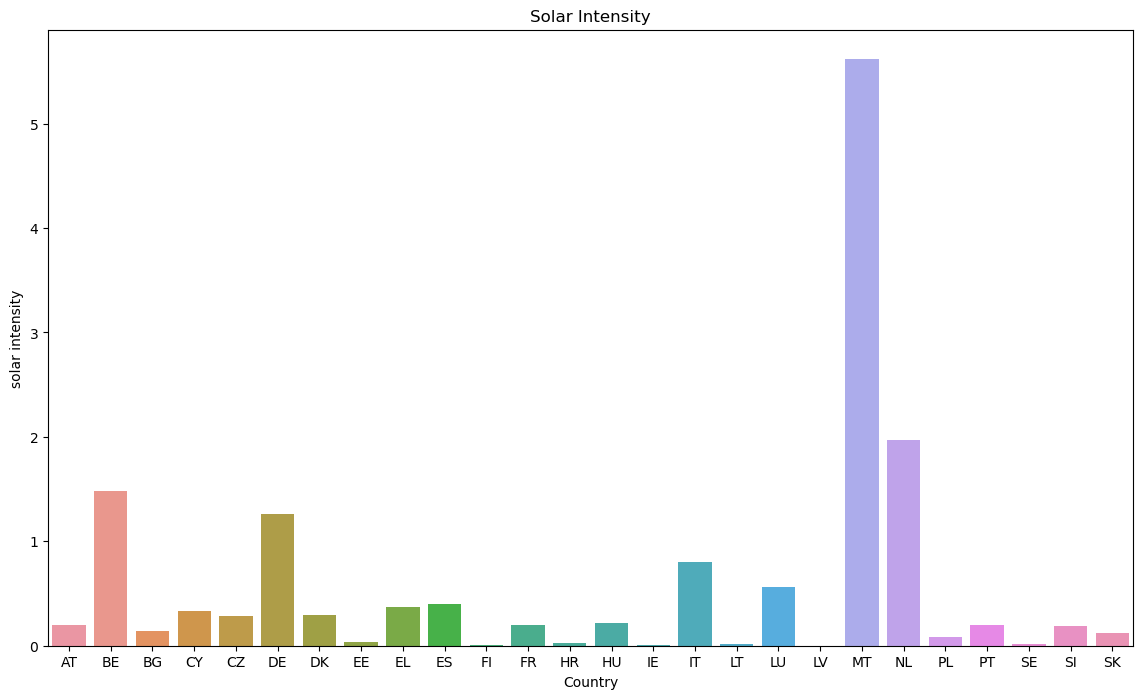

In [8]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(df_countries, x="geo", y="solar_power_intensity_[GWh_per_km2]")
ax = ax.set(xlabel='Country', ylabel='solar intensity', title='Solar Intensity')